## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon, MultiLineString, Point, LineString

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [34]:
save = True
save_space = True

## Required data

In [20]:
res = 9

### Required data - Area of Interest

['Aguascalientes' 'Jesús María' 'San Francisco de los Romo']


<Axes: >

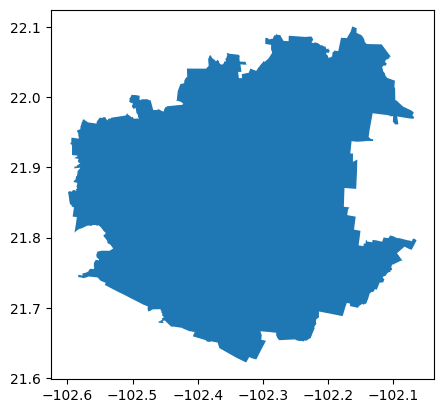

In [16]:
city = 'Aguascalientes'

# Source Data
schema = 'metropolis'
folder = 'metro_gdf'

# Downloads hexagons within 'city'
query = f"SELECT * FROM {schema}.{folder} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

print(mun_gdf.NOMGEO.unique())

mun_gdf = mun_gdf.set_crs("EPSG:4326")
aoi = mun_gdf.dissolve()
aoi = aoi[['city','geometry']]

# Saves space in disk if instructed
if save_space:
    del mun_gdf

#Show
aoi.plot()

### Required data - nodes with distance to nearest amenity from notebook prox_loading_osmnx 3 [Script 02_distance_amenities]

In [5]:
nodes_sources = gpd.read_file('../../data/external/temporal_fromjupyter/nodes_proximity_2020.gpkg')

#---------------------------------------------------------------------------------------------------------------------------------------------------------
print(f"Downloaded a total of {nodes_sources.shape[0]} nodes.")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

#Show
print(nodes_sources.shape)
print(nodes_sources.dtypes)
nodes_sources.head(2)

Downloaded a total of 1560458 nodes.
(1560458, 7)
osmid          int64
time         float64
source        object
city          object
x            float64
y            float64
geometry    geometry
dtype: object


,osmid,time,source,city,x,y,geometry
0,301189389,6.400245,denue_preescolar,Aguascalientes,-102.342212,21.848544,POINT (-102.34221 21.84854)
1,301189406,17.556360,denue_preescolar,Aguascalientes,-102.350222,21.850815,POINT (-102.35022 21.85082)


In [6]:
nodes = nodes_sources.copy()

#--------------- PREPARE DATA
#--------------- PREPARE DATA ---------- DELETE DUPLICATES AND CLEAN NODES
#This step keeps osmid, geometry and metropolis (without duplicates, keeping only one point for each node) to store times to each amenity source by node in following loop.
nodes_geom = nodes.drop_duplicates(subset='osmid', keep="last")[['osmid','geometry','city']].copy()

#--------------- PREPARE DATA ---------- REORGANIZE NODES DATA
#This step organizes data by nodes by changing (time to source amenities) from rows (1 column with source amenity name + 1 column with time data) 
#to columns (1 column with time data named after its source amenity)
nodes_analysis = nodes_geom.copy()

for source_amenity in list(nodes.source.unique()):
    nodes_tmp = nodes.loc[nodes.source == source_amenity,['osmid','time']]
    nodes_tmp = nodes_tmp.rename(columns={'time':source_amenity})
    # Search for amenities that aren't present in the city (with all values marked as 0) and change them to NaN
    if nodes_tmp[source_amenity].mean() == 0:
        nodes_tmp[source_amenity] = np.nan
    nodes_analysis = nodes_analysis.merge(nodes_tmp, on='osmid')

if save_space:
    del nodes_sources
    del nodes_geom
    del nodes_tmp

#---------------------------------------------------------------------------------------------------------------------------------------------------------
print("Transformed nodes data.")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

Transformed nodes data.


In [8]:
#Show
print(nodes_analysis.shape)
nodes_analysis.head(2)

(52013, 33)


,osmid,geometry,city,denue_preescolar,denue_primaria,denue_secundaria,clues_primer_nivel,denue_guarderias,denue_dif,denue_supermercado,...,denue_restaurante_insitu,denue_restaurante_llevar,denue_bares,denue_cafe,sip_cancha,sip_unidad_deportiva,sip_espacio_publico,denue_parque_natural,denue_cines,denue_museos
0,301189389,POINT (-102.34221 21.84854),Aguascalientes,6.400245,6.400245,2.133810,49.969125,5.135355,35.372640,31.292565,...,5.639280,2.802210,38.864595,2.133810,152.447610,79.55634,9.610185,NaN,81.32691,37.025325
1,301189406,POINT (-102.35022 21.85082),Aguascalientes,17.556360,17.556360,14.897805,50.857980,16.302480,46.539765,44.056560,...,16.795395,13.969335,48.043620,14.897805,140.144235,91.38255,20.766300,NaN,89.40900,45.107415


In [9]:
#--------------- PREPARE DATA ---------- SET PARAMETER DEFINITIONS
    #This step sets the ejes, amenidades, sources and weights for further analysis
    #{Eje (e):
    #         {Amenidad (a):
    #                       {Source (s))}}}
idx_15_min = {'Escuelas':{'Preescolar':['denue_preescolar'],
                          'Primaria':['denue_primaria'],
                          'Secundaria':['denue_secundaria']},
             'Servicios comunitarios':{'Salud':['clues_primer_nivel'],
                                       'Guarderías':['denue_guarderias'],
                                       'Asistencia social':['denue_dif']},
              'Comercio':{'Alimentos':['denue_supermercado','denue_abarrotes',
                                       'denue_carnicerias','sip_mercado'],
                          'Personal':['denue_peluqueria'],
                          'Farmacias':['denue_farmacias'],
                          'Hogar':['denue_ferreteria_tlapaleria','denue_art_limpieza'],
                          'Complementarios':['denue_ropa','denue_calzado','denue_muebles',
                                             'denue_lavanderia','denue_revistas_periodicos',
                                             'denue_pintura']},
              'Entretenimiento':{'Social':['denue_restaurante_insitu','denue_restaurante_llevar',
                                           'denue_bares','denue_cafe'],
                                 'Actividad física':['sip_cancha','sip_unidad_deportiva',
                                                    'sip_espacio_publico','denue_parque_natural'],
                                 'Cultural':['denue_cines','denue_museos']} 
             }

#If weight of amenity is less than number of sources, the algorith chooses the minimum time to source. 
#Else (if equall or greater), the algorithm chooses max time.
wegiht_idx = {'Escuelas':{'Preescolar':1,
                          'Primaria':1,
                          'Secundaria':1},
              'Servicios comunitarios':{'Salud':1,
                                        'Guarderías':1,
                                        'Asistencia social':1},
              'Comercio':{'Alimentos':1, #Will choose min time to source.
                          'Personal':1,
                          'Farmacias':1,
                          'Hogar':1, #Will choose min time to source.
                          'Complementarios':1},  #Will choose min time to source.
              'Entretenimiento':{'Social':4,
                                 'Actividad física':1,  #Will choose min time to source.
                                 'Cultural':1}  #Will choose min time to source.
            }    
    
#--------------- PREPARE DATA ---------- FILL MISSING COLUMNS (In case there is a source amenity not available in a city)
sources = []

# Gather all possible sources
for eje in idx_15_min.keys():
    for amenity in idx_15_min[eje].values():
        for source in amenity:
            sources.append(source)
            
# If source not in currently analized city, fill column with np.nan
column_list = list(nodes_analysis.columns)
missing_sourceamenities = []

for s in sources:
        if s not in column_list:
            nodes_analysis[s] = np.nan
            #---------------------------------------------------------------------------------------------------------------------------------------------
            print(f"{s} source amenity is not present in {city}.")
            #---------------------------------------------------------------------------------------------------------------------------------------------
            missing_sourceamenities.append(s)
            
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print(f"Finished missing source amenities analysis. {len(missing_sourceamenities)} not present source amenities were added as np.nan columns")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

Finished missing source amenities analysis. 0 not present source amenities were added as np.nan columns


In [12]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print("Starting proximity to amenities analysis by node.")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

#--------------- PROCESS DATA 
#--------------- PROCESS DATA ---------- Max time calculation
#This step calculates times by amenity

column_max_all = [] # list with all max index column names
column_max_ejes = [] # list with ejes index column names

#Goes through each eje in dictionary:
for e in idx_15_min.keys():

    #Appends to 3 lists currently examined eje
    column_max_all.append('max_'+ e.lower())
    column_max_ejes.append('max_'+ e.lower())
    column_max_amenities = [] # list with amenities in current eje

    #Goes through each amenity of current eje:
    for a in idx_15_min[e].keys():

        #Appends to 2 lists currently examined amenity:
        column_max_all.append('max_'+ a.lower())
        column_max_amenities.append('max_'+ a.lower())

        #Calculates time to currently examined amenity:
        #If weight is less than number of sources of amenity, choose minimum time to sources.
        if wegiht_idx[e][a] < len(idx_15_min[e][a]): 
            nodes_analysis['max_'+ a.lower()] = nodes_analysis[idx_15_min[e][a]].min(axis=1)
        #Else, choose maximum time to sources.
        else:
            nodes_analysis['max_'+ a.lower()] = nodes_analysis[idx_15_min[e][a]].max(axis=1)

    #Calculates time to currently examined eje (max time of its amenities):
    nodes_analysis['max_'+ e.lower()] = nodes_analysis[column_max_amenities].max(axis=1) 

index_column = 'max_time' # column name for maximum time data

#Add to column_max_all list the attribute 'max_time'
column_max_all.append(index_column)

#Assigns "max_time" the max time for all ejes
nodes_analysis[index_column] = nodes_analysis[column_max_ejes].max(axis=1)     

#Add to column_max_all list the attributes 'osmid' and 'geometry' to filter nodes_analysis with the column_max_all list.
column_max_all.append('osmid')
column_max_all.append('geometry')
nodes_analysis_filter = nodes_analysis[column_max_all].copy()

if save_space:
    del nodes_analysis
    
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print("Calculated proximity to amenities data by node.")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

Starting proximity to amenities analysis by node.
Calculated proximity to amenities data by node.


In [15]:
#Show
print(nodes_analysis_filter.shape)
nodes_analysis_filter.head(2)

(52013, 21)


,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,max_asistencia social,max_comercio,max_alimentos,...,max_farmacias,max_hogar,max_complementarios,max_entretenimiento,max_social,max_actividad física,max_cultural,max_time,osmid,geometry
0,6.400245,6.400245,6.400245,2.133810,49.969125,49.969125,5.135355,35.372640,2.802210,2.802210,...,0.207180,0.207180,0.207180,38.864595,38.864595,9.610185,37.025325,49.969125,301189389,POINT (-102.34221 21.84854)
1,17.556360,17.556360,17.556360,14.897805,50.857980,50.857980,16.302480,46.539765,13.969335,13.969335,...,13.440945,13.440945,13.440945,48.043620,48.043620,20.766300,45.107415,50.857980,301189406,POINT (-102.35022 21.85082)


In [25]:
#--------------- PROCESS DATA ---------- GROUP TIMES BY HEXAGONS
# Create hexgrid
hexgrid = aup.create_hexgrid(aoi,res)
hexgrid = hexgrid.set_crs("EPSG:4326")

#---------------------------------------------------------------------------------------------------------------------------------------------------------
print(f"Created hexgrid of resolution {res}")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

#Show
print(hexgrid.shape)
hexgrid.head(2)

Created hexgrid of resolution 9
(14612, 2)


,hex_id_9,geometry
0,89498e3420fffff,"POLYGON ((-102.21746 21.95460, -102.21622 21.9..."
1,894988cb423ffff,"POLYGON ((-102.35652 21.97058, -102.35528 21.9..."


In [27]:
# group data by hex
hex_tmp = hexgrid.copy()
hex_idx = aup.group_by_hex_mean(nodes_analysis_filter, hex_tmp, res, index_column)
hex_idx = hex_idx.loc[hex_idx[index_column]>0].copy()

if save_space:
    del hex_tmp
    del nodes_analysis_filter
    
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print(f"Grouped nodes data by hexagons res {res}")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

Grouped nodes data by hexagons res 9


In [28]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print('Recalculating times in hexagons')
#---------------------------------------------------------------------------------------------------------------------------------------------------------

#--------------- PROCESS DATA ---------- RE-CALCULATE MAX TIMES BY HEXAGON
# This step recalculates max time to each eje from max times to calculated amenities and max_time from max eje
column_max_ejes = [] # list with ejes index column names

#Goes (again) through each eje in dictionary:
for e in idx_15_min.keys():

    column_max_ejes.append('max_'+ e.lower())
    column_max_amenities = [] # list with amenities in current eje

    #Goes (again) through each amenity of current eje:    
    for a in idx_15_min[e].keys():

        column_max_amenities.append('max_'+ a.lower())

    #Re-calculates time to currently examined eje (max time of its amenities):        
    hex_idx['max_'+ e.lower()] = hex_idx[column_max_amenities].max(axis=1)

hex_idx[index_column] = hex_idx[column_max_ejes].max(axis=1)

#Add to column_max_all list the attribute 'max_time'
column_max_ejes.append(index_column)

#---------------------------------------------------------------------------------------------------------------------------------------------------------
print('Finished recalculating times in hexagons')
#---------------------------------------------------------------------------------------------------------------------------------------------------------

Recalculating times in hexagons
Finished recalculating times in hexagons


In [29]:
#--------------- PROCESS DATA ---------- INDEX, MEDIAN AND MEAN CALCULATION
# This step adds data

#Define function
def apply_sigmoidal(x):
    if x == -1:
        return -1
    elif x > 1000:
        return 0
    else:
        val = aup.sigmoidal_function(0.1464814753435666, x, 30)
        return val

#Apply function
amenities_col = ['max_preescolar','max_primaria','max_secundaria',
           'max_salud','max_guarderías','max_asistencia social',
           'max_alimentos','max_personal','max_farmacias','max_hogar',
           'max_complementarios','max_social','max_actividad física',
           'max_cultural']
for ac in amenities_col:
    idx_col = ac.replace('max','idx')
    hex_idx[idx_col] = hex_idx[ac].apply(apply_sigmoidal)

#Add data
idx_colname = []
for ac in amenities_col:
    idx_col = ac.replace('max','idx')
    idx_colname.append(idx_col)

hex_idx['mean_time'] = hex_idx[amenities_col].mean(axis=1)
hex_idx['median_time'] = hex_idx[amenities_col].median(axis=1)
hex_idx['idx_sum'] = hex_idx[idx_colname].sum(axis=1)

print('Finished calculating index, mean and median time')

Finished calculating index, mean and median time


In [30]:
#--------------- PROCESS DATA ---------- ADD POP AND CITY DATA
# calculate population density
#hex_pop = hex_pop.to_crs("EPSG:6372")
#hex_pop['dens_pobha'] = hex_pop['pobtot'] / (hex_pop.area/10000)
#hex_pop = hex_pop.to_crs("EPSG:4326")

# Add pop data
#pop_list = ['hex_id_9','pobtot','dens_pobha']
#hex_res_9_idx = pd.merge(hex_res_9_idx, hex_pop[pop_list], on='hex_id_9')

#if save_disk_space:
#    del hex_pop

# Add city data
hex_idx['city'] = city

print('Finished adding pop and city data')

Finished adding pop and city data


In [32]:
#--------------- FINAL FORMAT ----------
#--------------- FINAL FORMAT ---------- REORDER COLUMNS    
#Final format
final_column_ordered_list = ['hex_id_9', 'geometry', 
                             #Escuelas
                             'max_escuelas', 'max_preescolar', 'max_primaria', 'max_secundaria',
                             #Servicios comunitarios
                             'max_servicios comunitarios', 'max_salud', 'max_guarderías', 'max_asistencia social',
                             #Comercio
                             'max_comercio', 'max_alimentos', 'max_personal', 'max_farmacias', 'max_hogar', 'max_complementarios',
                             #Entretenimiento
                             'max_entretenimiento', 'max_social', 'max_actividad física', 'max_cultural', 
                             #Escuelas
                             'idx_preescolar', 'idx_primaria', 'idx_secundaria',
                             #Servicios comunitarios
                             'idx_salud', 'idx_guarderías', 'idx_asistencia social',
                             #Comercio
                             'idx_alimentos', 'idx_personal', 'idx_farmacias', 'idx_hogar', 'idx_complementarios',
                             #Entretenimiento
                             'idx_social', 'idx_actividad física', 'idx_cultural',
                             #Mean, median, max, index
                             'mean_time', 'median_time', 'max_time', 'idx_sum',
                             #Pop data
                             #'pobtot', 'dens_pobha',
                             #City data
                             'city']

hex_idx_city = hex_idx[final_column_ordered_list]

if save_space:
    del hex_idx

print('Finished final format')

Finished final format


In [33]:
if save:
    hex_idx_city.to_file('../../data/external/temporal_fromjupyter/proximityanalysis_hexres9.gpkg', driver='GPKG')